In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua

In [6]:
def get_adj(station, var):
    import datetime
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    if var == 'RAOBCORE_bias_estimate':
        file = ('./Temperature_adjustment/0'+station+'/feedbackglobbincorrsave0'+station+'.nc')
    elif var == 'RISE_bias_estimate':
        file = glob.glob('./Temperature_adjustment/0'+station+'/*corrsave*rio24*'+station+'.nc')[0]
    data = eua.CDMDataset(file)
    
    breakdates = []
    for i in data.datum[:][0]:
        breakdates.append(date0 + datetime.timedelta(days=int(i)))
    
    press = data.press[:]
    nightadj = data.rasocorr[0,:]
    dayadj = data.rasocorr[1,:]
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': 'temperature',
                    'optional':['obs_minus_bg','bias_estimate','RISE_bias_estimate', 'RICH_bias_estimate', 'RASE_bias_estimate', 'RAOBCORE_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daydata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    print(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    
#     breakdates.append(str(cdsdata.time.iloc[0]))#.year)+str(cdsdata.time.iloc[0].month)+str(cdsdata.time.iloc[0].day))
    dates = breakdates
#     dates.reverse()
    print(dates)
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daydata[daydata.plev == press[j]*100][daydata.time >= dates[i]][daydata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd.RAOBCORE_bias_estimate.iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightdata[nightdata.plev == press[j]*100][nightdata.time >= dates[i]][nightdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd.RAOBCORE_bias_estimate.iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, calc_day_out, calc_night_out, cds_day_out, cds_night_out

In [7]:
def plt_adj(dates, cdata, adata, plev, station, time, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    ax.scatter(dates[1:], cdata[str(plev)], label='CDS')
    ax.scatter(dates[1:], adata[str(plev)], label='Calc')

    ax.set(xlabel='breaks', ylabel='Adjustment',
           title= str(station)+' Temperature '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

2021-04-27 09:30:49,577 INFO Welcome to the CDS
2021-04-27 09:30:49,577 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:30:49,897 INFO Request is completed
2021-04-27 09:30:49,898 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-27 09:30:52,551 INFO Download rate 10.6M/s  
2021-04-27 09:30:52,686 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 12, 0, 0), datetime.datetime(1952, 6, 17, 0, 0), datetime.datetime(1955, 7, 20, 0, 0), datetime.datetime(1956, 8, 4, 0, 0), datetime.datetime(1958, 8, 12, 0, 0), datetime.datetime(1960, 11, 11, 0, 0), datetime.datetime(1963, 9, 6, 0, 0), datetime.datetime(1964, 12, 20, 0, 0), datetime.datetime(1970, 9, 6, 0, 0), datetime.datetime(1975, 8, 6, 0, 0), datetime.datetime(1977, 12, 3, 0, 0), datetime.datetime(1980, 9, 13, 0, 0), datetime.datetime(1982, 11, 20, 0, 0), datetime.datetime(1984, 1, 26, 0, 0), datetime.datetime(1989, 6, 30, 0, 0), datetime.datetime(1992, 2, 27, 0, 0), datetime.datetime(1995, 6, 11, 0, 0), datetime.datetime(1997, 7, 11, 0, 0), datetime.datetime(1999, 9, 4, 0, 0), datetime.datetime(2009, 3, 20, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


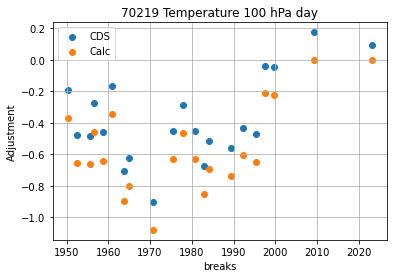

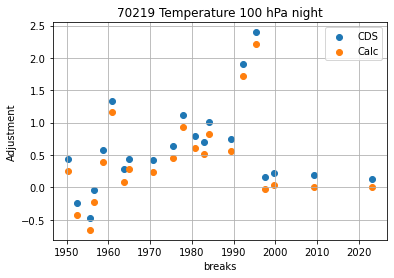

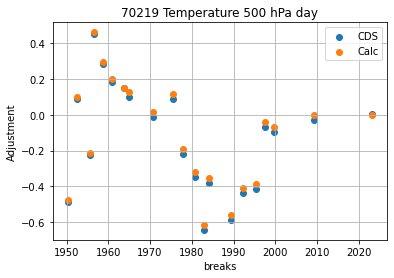

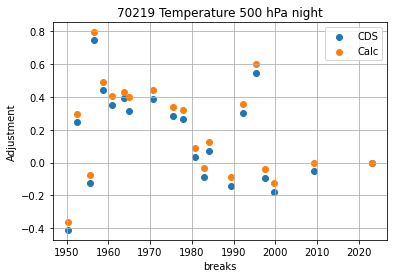

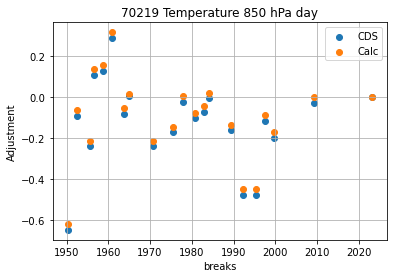

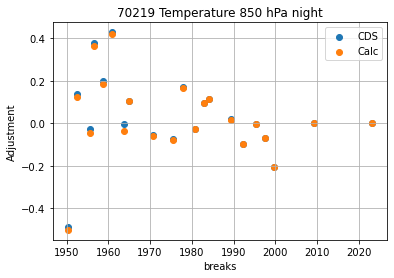

In [8]:
station = '70219'
dates, cd, cn, ad, an = get_adj(station, 'RAOBCORE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:31:13,464 INFO Welcome to the CDS
2021-04-27 09:31:13,465 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:31:13,598 INFO Request is completed
2021-04-27 09:31:13,599 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619430583.4392266-16861-7-46ce0851-f55c-451f-a96d-294334bd80dd.zip to download.zip (28.1M)
2021-04-27 09:31:17,854 INFO Download rate 6.6M/s   
2021-04-27 09:31:17,953 INFO Reading Profile on slice(None, None, None)


1948-01-01 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 4, 13, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1955, 7, 21, 0, 0), datetime.datetime(1956, 8, 5, 0, 0), datetime.datetime(1958, 8, 13, 0, 0), datetime.datetime(1960, 11, 12, 0, 0), datetime.datetime(1963, 9, 7, 0, 0), datetime.datetime(1964, 12, 21, 0, 0), datetime.datetime(1970, 9, 7, 0, 0), datetime.datetime(1975, 8, 7, 0, 0), datetime.datetime(1977, 12, 4, 0, 0), datetime.datetime(1980, 9, 14, 0, 0), datetime.datetime(1982, 11, 21, 0, 0), datetime.datetime(1984, 1, 27, 0, 0), datetime.datetime(1989, 7, 1, 0, 0), datetime.datetime(1992, 2, 28, 0, 0), datetime.datetime(1995, 6, 12, 0, 0), datetime.datetime(1997, 7, 12, 0, 0), datetime.datetime(1999, 9, 5, 0, 0), datetime.datetime(2009, 3, 21, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


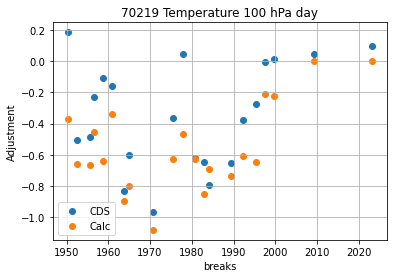

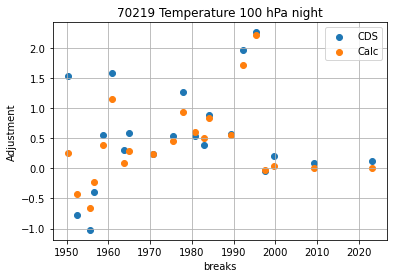

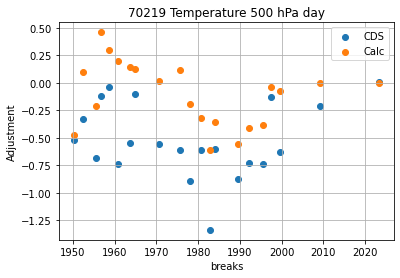

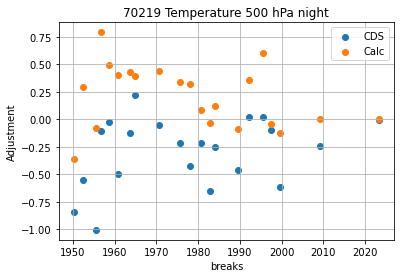

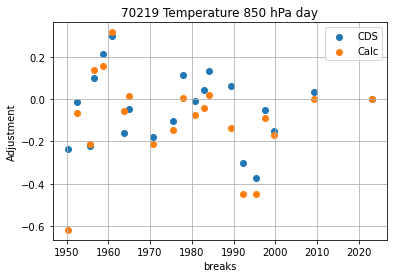

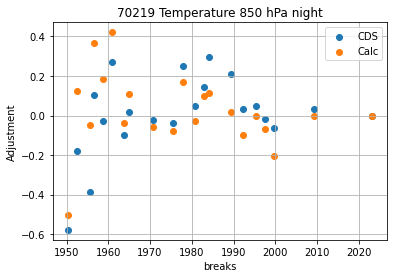

In [9]:
station = '70219'
dates, cd, cn, ad, an = get_adj(station, 'RISE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:32:41,375 INFO Welcome to the CDS
2021-04-27 09:32:41,376 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:32:41,619 INFO Request is completed
2021-04-27 09:32:41,620 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-27 09:32:42,976 INFO Download rate 22.7M/s  
2021-04-27 09:32:43,077 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 18, 0, 0), datetime.datetime(1956, 4, 28, 0, 0), datetime.datetime(1958, 5, 19, 0, 0), datetime.datetime(1959, 4, 1, 0, 0), datetime.datetime(1960, 5, 27, 0, 0), datetime.datetime(1965, 7, 12, 0, 0), datetime.datetime(1967, 11, 27, 0, 0), datetime.datetime(1972, 3, 13, 0, 0), datetime.datetime(1975, 1, 4, 0, 0), datetime.datetime(1978, 12, 31, 0, 0), datetime.datetime(1981, 1, 25, 0, 0), datetime.datetime(1981, 10, 14, 0, 0), datetime.datetime(1984, 5, 31, 0, 0), datetime.datetime(1988, 1, 26, 0, 0), datetime.datetime(1990, 6, 14, 0, 0), datetime.datetime(1995, 11, 22, 0, 0), datetime.datetime(2003, 4, 26, 0, 0), datetime.datetime(2011, 6, 1, 0, 0), datetime.datetime(2014, 11, 12, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


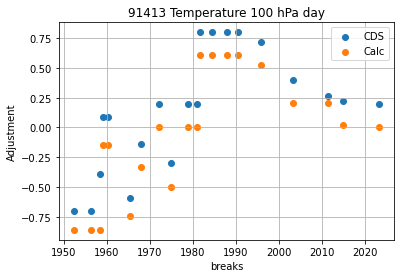

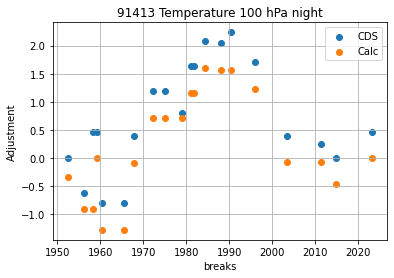

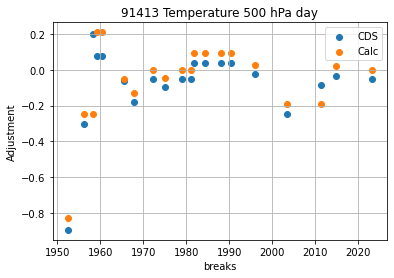

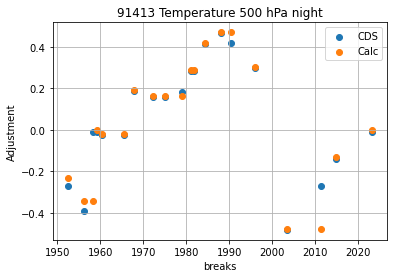

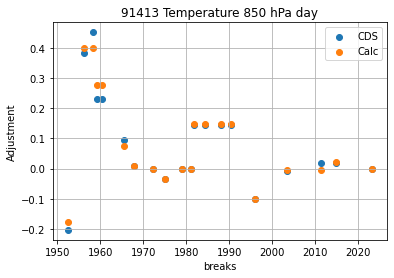

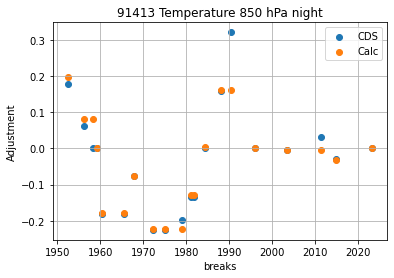

In [10]:
station = '91413'
dates, cd, cn, ad, an = get_adj(station, 'RAOBCORE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:32:58,859 INFO Welcome to the CDS
2021-04-27 09:32:58,860 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:32:58,997 INFO Request is completed
2021-04-27 09:32:58,999 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619442520.2651842-22152-13-aa2a8e19-41a7-483e-989b-4b5c889b4b2b.zip to download.zip (30.7M)
2021-04-27 09:33:00,302 INFO Download rate 23.6M/s  
2021-04-27 09:33:00,407 INFO Reading Profile on slice(None, None, None)


1948-12-11 03:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 6, 19, 0, 0), datetime.datetime(1956, 4, 29, 0, 0), datetime.datetime(1958, 5, 20, 0, 0), datetime.datetime(1959, 4, 2, 0, 0), datetime.datetime(1960, 5, 28, 0, 0), datetime.datetime(1972, 3, 14, 0, 0), datetime.datetime(1975, 1, 5, 0, 0), datetime.datetime(1979, 1, 1, 0, 0), datetime.datetime(1981, 1, 26, 0, 0), datetime.datetime(1981, 10, 15, 0, 0), datetime.datetime(1984, 6, 1, 0, 0), datetime.datetime(1988, 1, 27, 0, 0), datetime.datetime(1990, 6, 15, 0, 0), datetime.datetime(1995, 11, 23, 0, 0), datetime.datetime(2003, 4, 27, 0, 0), datetime.datetime(2011, 6, 2, 0, 0), datetime.datetime(2014, 11, 13, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


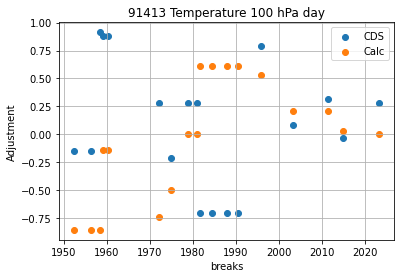

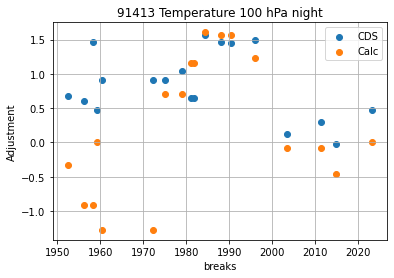

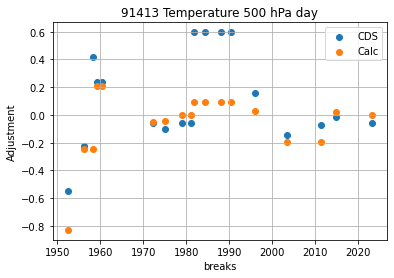

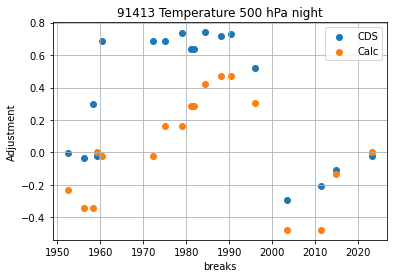

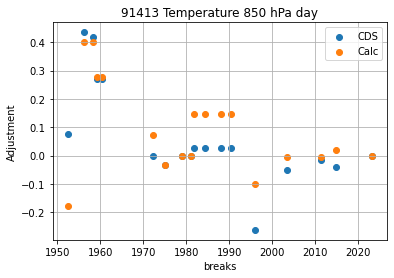

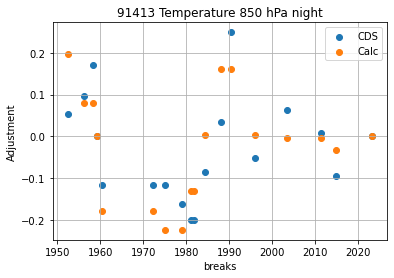

In [11]:
station = '91413'
dates, cd, cn, ad, an = get_adj(station, 'RISE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:33:15,843 INFO Welcome to the CDS
2021-04-27 09:33:15,844 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:33:15,917 INFO Request is completed
2021-04-27 09:33:15,918 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-27 09:33:23,438 INFO Download rate 5.8M/s   
2021-04-27 09:33:23,620 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 2, 0, 0), datetime.datetime(1957, 1, 21, 0, 0), datetime.datetime(1960, 1, 16, 0, 0), datetime.datetime(1962, 2, 8, 0, 0), datetime.datetime(1963, 2, 11, 0, 0), datetime.datetime(1968, 1, 3, 0, 0), datetime.datetime(1970, 3, 3, 0, 0), datetime.datetime(1973, 4, 30, 0, 0), datetime.datetime(1979, 11, 2, 0, 0), datetime.datetime(1984, 8, 6, 0, 0), datetime.datetime(1987, 1, 17, 0, 0), datetime.datetime(1989, 4, 2, 0, 0), datetime.datetime(1991, 2, 16, 0, 0), datetime.datetime(1992, 3, 24, 0, 0), datetime.datetime(1994, 10, 12, 0, 0), datetime.datetime(2004, 5, 12, 0, 0), datetime.datetime(2006, 7, 1, 0, 0), datetime.datetime(2010, 7, 10, 0, 0), datetime.datetime(2017, 2, 3, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


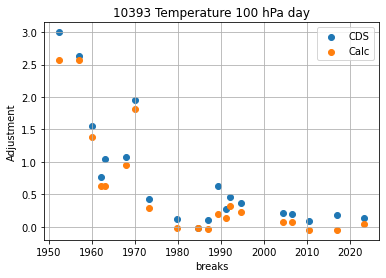

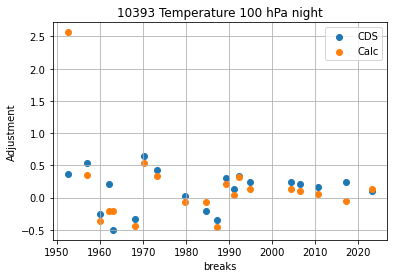

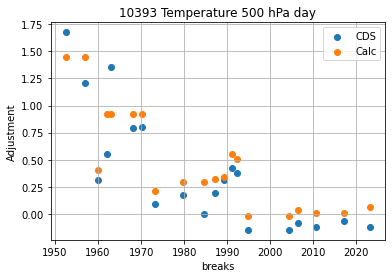

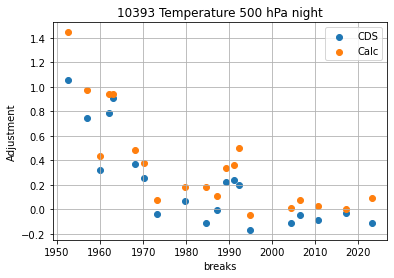

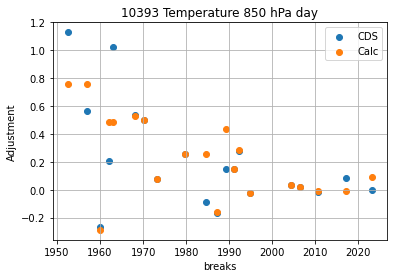

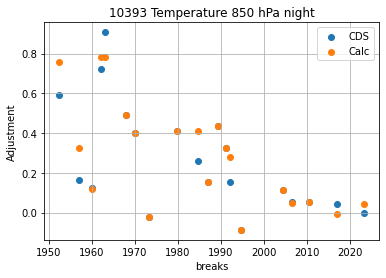

In [12]:
station = '10393'
dates, cd, cn, ad, an = get_adj(station, 'RAOBCORE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:33:53,780 INFO Welcome to the CDS
2021-04-27 09:33:53,781 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:33:53,950 INFO Request is completed
2021-04-27 09:33:53,951 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1619430493.9770315-17332-9-5b04736a-b6fb-42b3-9245-1237f01efa80.zip to download.zip (43.3M)
2021-04-27 09:34:03,630 INFO Download rate 4.5M/s   
2021-04-27 09:34:03,773 INFO Reading Profile on slice(None, None, None)


1905-04-04 06:00:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1952, 7, 3, 0, 0), datetime.datetime(1957, 1, 22, 0, 0), datetime.datetime(1960, 1, 17, 0, 0), datetime.datetime(1962, 2, 9, 0, 0), datetime.datetime(1963, 2, 12, 0, 0), datetime.datetime(1968, 1, 4, 0, 0), datetime.datetime(1970, 3, 4, 0, 0), datetime.datetime(1973, 5, 1, 0, 0), datetime.datetime(1979, 11, 3, 0, 0), datetime.datetime(1984, 8, 7, 0, 0), datetime.datetime(1987, 1, 18, 0, 0), datetime.datetime(1989, 4, 3, 0, 0), datetime.datetime(1991, 2, 17, 0, 0), datetime.datetime(1992, 3, 25, 0, 0), datetime.datetime(1994, 10, 13, 0, 0), datetime.datetime(2004, 5, 13, 0, 0), datetime.datetime(2006, 7, 2, 0, 0), datetime.datetime(2010, 7, 11, 0, 0), datetime.datetime(2017, 2, 4, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


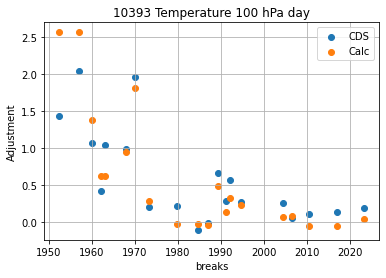

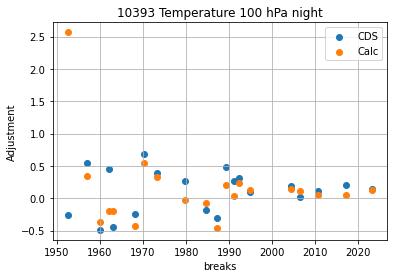

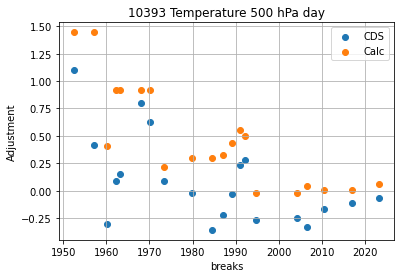

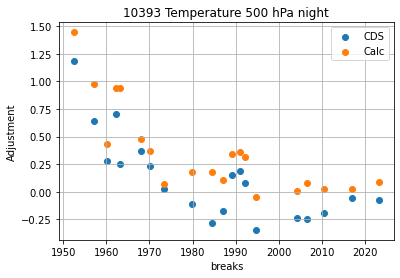

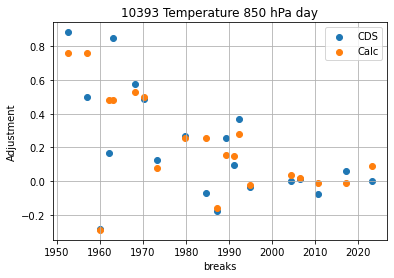

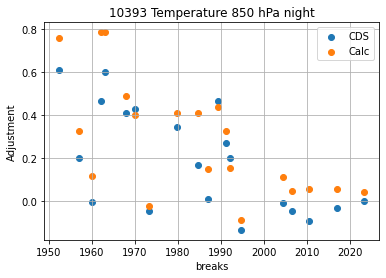

In [13]:
station = '10393'
dates, cd, cn, ad, an = get_adj(station, 'RISE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:34:35,998 INFO Welcome to the CDS
2021-04-27 09:34:35,999 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:34:36,181 INFO Request is completed
2021-04-27 09:34:36,182 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-27 09:34:41,090 INFO Download rate 5.9M/s   
2021-04-27 09:34:41,186 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 2, 25, 0, 0), datetime.datetime(1951, 9, 12, 0, 0), datetime.datetime(1954, 2, 28, 0, 0), datetime.datetime(1956, 7, 4, 0, 0), datetime.datetime(1958, 6, 23, 0, 0), datetime.datetime(1963, 11, 8, 0, 0), datetime.datetime(1965, 8, 14, 0, 0), datetime.datetime(1966, 10, 23, 0, 0), datetime.datetime(1968, 1, 1, 0, 0), datetime.datetime(1969, 9, 29, 0, 0), datetime.datetime(1973, 2, 13, 0, 0), datetime.datetime(1974, 11, 21, 0, 0), datetime.datetime(1976, 2, 3, 0, 0), datetime.datetime(1980, 3, 30, 0, 0), datetime.datetime(1982, 1, 8, 0, 0), datetime.datetime(1984, 1, 9, 0, 0), datetime.datetime(1987, 4, 16, 0, 0), datetime.datetime(1989, 8, 23, 0, 0), datetime.datetime(1994, 6, 4, 0, 0), datetime.datetime(1996, 8, 11, 0, 0), datetime.datetime(2016, 12, 14, 0, 0), datetime.datetime(2018, 12, 15, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


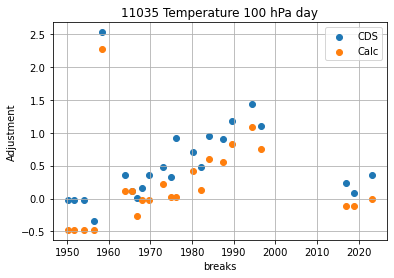

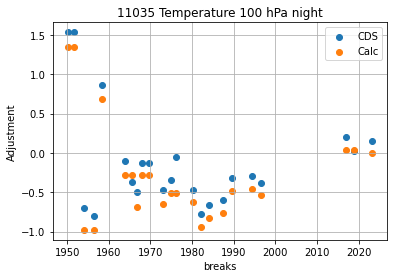

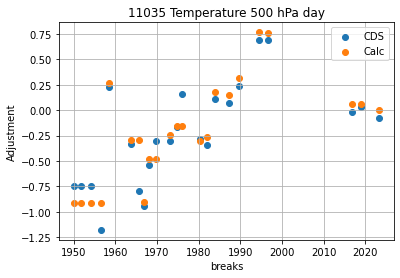

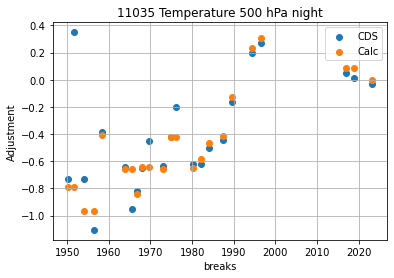

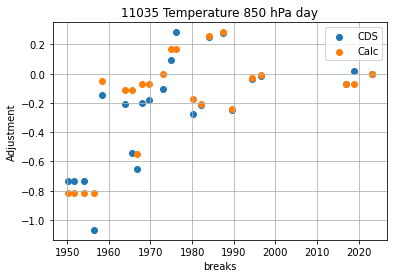

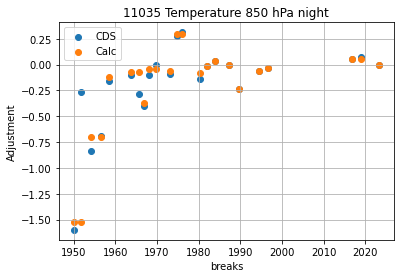

In [14]:
station = '11035'
dates, cd, cn, ad, an = get_adj(station,'RAOBCORE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)

2021-04-27 09:35:00,379 INFO Welcome to the CDS
2021-04-27 09:35:00,380 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-04-27 09:35:00,518 INFO Request is completed
2021-04-27 09:35:00,519 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1619418957.6919405-22674-5-9bd54766-c124-49e5-9fde-f2fdec5cb266.zip to download.zip (29M)
2021-04-27 09:35:05,641 INFO Download rate 5.7M/s   
2021-04-27 09:35:05,742 INFO Reading Profile on slice(None, None, None)


1925-01-24 09:22:00
[datetime.datetime(1900, 1, 2, 0, 0), datetime.datetime(1950, 2, 26, 0, 0), datetime.datetime(1951, 9, 13, 0, 0), datetime.datetime(1954, 3, 1, 0, 0), datetime.datetime(1956, 7, 5, 0, 0), datetime.datetime(1958, 6, 24, 0, 0), datetime.datetime(1963, 11, 9, 0, 0), datetime.datetime(1965, 8, 15, 0, 0), datetime.datetime(1966, 10, 24, 0, 0), datetime.datetime(1968, 1, 2, 0, 0), datetime.datetime(1969, 9, 30, 0, 0), datetime.datetime(1973, 2, 14, 0, 0), datetime.datetime(1974, 11, 22, 0, 0), datetime.datetime(1976, 2, 4, 0, 0), datetime.datetime(1980, 3, 31, 0, 0), datetime.datetime(1982, 1, 9, 0, 0), datetime.datetime(1984, 1, 10, 0, 0), datetime.datetime(1987, 4, 17, 0, 0), datetime.datetime(1989, 8, 24, 0, 0), datetime.datetime(1994, 6, 5, 0, 0), datetime.datetime(1996, 8, 12, 0, 0), datetime.datetime(2016, 12, 15, 0, 0), datetime.datetime(2018, 12, 16, 0, 0), datetime.datetime(2023, 3, 15, 0, 0)]


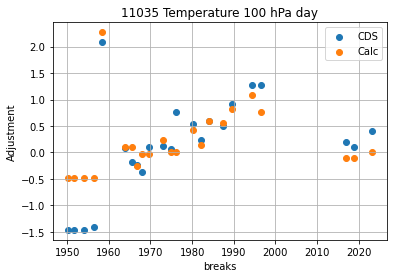

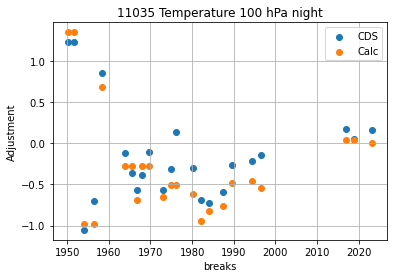

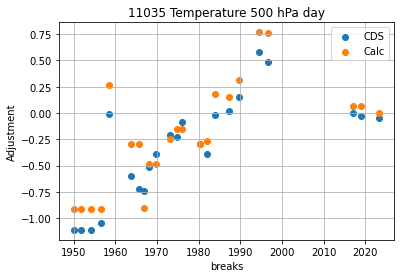

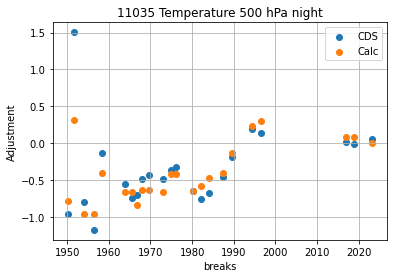

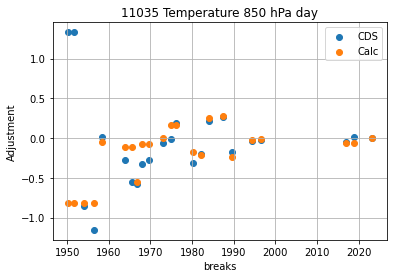

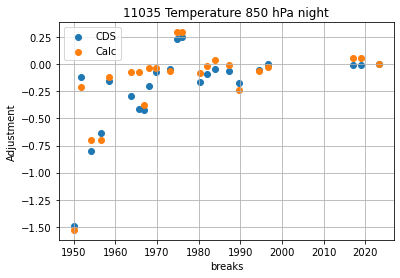

In [15]:
station = '11035'
dates, cd, cn, ad, an = get_adj(station,'RISE_bias_estimate')
plt_adj(dates, cd, ad, 100, station, 'day', save=False)
plt_adj(dates, cn, an, 100, station, 'night', save=False)
plt_adj(dates, cd, ad, 500, station, 'day', save=False)
plt_adj(dates, cn, an, 500, station, 'night', save=False)
plt_adj(dates, cd, ad, 850, station, 'day', save=False)
plt_adj(dates, cn, an, 850, station, 'night', save=False)